In [1]:
from scipy import io
from pathlib import Path

import numpy as np
rng = np.random.default_rng()

import jax.numpy as jnp
import jax.random as jr

import optax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from dynamax.hidden_markov_model import LinearRegressionHMM
from dynamax.utils.plotting import gradient_cmap

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Utility

In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink",
    "greyish",
    "light blue",
    "green",
    "yellow",
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
def plot_emissions_and_states(emissions, most_likely_states, posterior, cmap, colors):
    
    plot_slice = (0, emissions.shape[0])
    emission_dim = emissions.shape[-1]
    time_bins = emissions.shape[0]
    state_probability_spread = posterior.smoothed_probs.T
    lim = 1.1 * max(abs(emissions).max(), 1)
    # lim = 1

    plt.figure(figsize=(8, 6))
    plt.suptitle("Emissions and Inferred States", y=1.01)

    # Plot number 1
    plt.subplot(211)

    im = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors)-1,
        extent=(0, time_bins, 0, (emission_dim)*lim)
    )

    values = np.unique(most_likely_states.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label=f"State {values[i] + 1}") for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Most Likely Z")

    # emissions line
    for d in range(emission_dim):
        plt.plot(emissions[:,d] + lim * d, '-k')

    plt.xlim(plot_slice)
    plt.yticks([+1, 0])


    # Plot number 2
    plt.subplot(212)
    plt.imshow(state_probability_spread, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    plt.xlim(plot_slice)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks(ticks=range(state_probability_spread.shape[0]), labels=np.array(range(state_probability_spread.shape[0])) + 1)
    plt.xlabel("time")

    plt.show()

def plot_lps(lps): 
    plt.figure(figsize=(6, 3))
    # true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
    plt.plot(lps, label="EM")
    # plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()

def plot_validation(cross_valids, show_var = True, max_states = 7):
    avg_val_lls = cross_valids.mean(axis=1)
    plt.plot(range(2, max_states), avg_val_lls, '-ko')
    if show_var:
        for k, per_fold_val_lls in zip(range(2, max_states), cross_valids):
            plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
    plt.xticks(range(2, max_states))
    plt.xlabel("num states ($K$)")
    plt.ylabel("avg. validation log prob.")
    plt.show()

## Loading Data

In [4]:
design_matrix = np.load("../cache/data_prep/design_matrix.npy")
observation = np.load("../cache/data_prep/observation.npy")

design_matrix.shape, observation.shape

((312, 120, 3), (312, 120, 1))

In [5]:
train_emissions = observation
train_inputs = design_matrix

# train_emissions = train_emissions * 360
# train_inputs[:, :, 0] = train_inputs[:, :, 0] * 360
# train_inputs[:, :, 1] = train_inputs[:, :, 1] * 180
# train_inputs[:, :, 2] = train_inputs[:, :, 2] * 180

# add np.ones to train_inputs
# train_inputs = np.concatenate([train_inputs, np.zeros((312, 120, 1))], axis=2)

# train_inputs = np.repeat(train_inputs, 20, axis=0)
# train_emissions = np.repeat(train_emissions, 20, axis=0)

# if train_emmisions value is negative, make it 0
train_emissions[train_emissions < 0] = 0.5

train_inputs[train_inputs < 0] = 0

# convert to jax
train_emissions = jnp.array(train_emissions)
train_inputs = jnp.array(train_inputs)

## Fitting

In [6]:
def train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs):
    # Initialize with K-Means
    lrhmm = LinearRegressionHMM(num_states, input_dim, emission_dim)
    params, props = lrhmm.initialize(key=jr.PRNGKey(1), emissions=train_emissions)

    # Fit with EM
    fitted_params, lps = lrhmm.fit_sgd(params, props, train_emissions, num_epochs = 500 , inputs=train_inputs, optimizer=optax.adam(1e-4), shuffle=True, batch_size=1)
    # fitted_params, lps = lrhmm.fit_em(params, props, train_emissions, num_iters = 200 , inputs=train_inputs)

    return lrhmm, fitted_params, lps

In [23]:
all_models, all_params, all_lps = [], [], []

input_dim = 3
emission_dim = 1

min_state = 2
max_state = 7

for num_states in range(min_state, max_state):
    print(f'Training: {num_states} states')
    arhmm, fitted_params, lps = train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs)
    all_models.append(arhmm)
    all_params.append(fitted_params)
    all_lps.append(lps)


# log_likelihoods.shape (120, 2, 1)
    
# (0.0, Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=6/0)>)
# Traced<ShapedArray(int32[120])>with<DynamicJaxprTrace(level=6/0)>

Training: 2 states
Training: 3 states
log_likelihoods.shape (120, 3)
(0.0, Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=6/0)>)
Traced<ShapedArray(int32[120])>with<DynamicJaxprTrace(level=6/0)>
Training: 4 states
log_likelihoods.shape (120, 4)
(0.0, Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=6/0)>)
Traced<ShapedArray(int32[120])>with<DynamicJaxprTrace(level=6/0)>
Training: 5 states
log_likelihoods.shape (120, 5)
(0.0, Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=6/0)>)
Traced<ShapedArray(int32[120])>with<DynamicJaxprTrace(level=6/0)>
Training: 6 states
log_likelihoods.shape (120, 6)
(0.0, Traced<ShapedArray(float32[6])>with<DynamicJaxprTrace(level=6/0)>)
Traced<ShapedArray(int32[120])>with<DynamicJaxprTrace(level=6/0)>


In [24]:
all_lps[2][-10:]

Array([-1.172486  , -0.49867767, -1.1135294 , -0.7332613 , -0.21314003,
       -0.56311244, -1.2139082 , -1.1142508 , -1.136589  , -0.19459899],      dtype=float32)

In [25]:
# SGD

# for x in all_lps:
#     plt.plot(x, "-")
# plt.legend(range(min_state, max_state))
# plt.ylim(-2, 2)
# plt.xlim(0, 100)
# plt.title("SGD Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")

Text(0, 0.5, 'Log Likelihood')

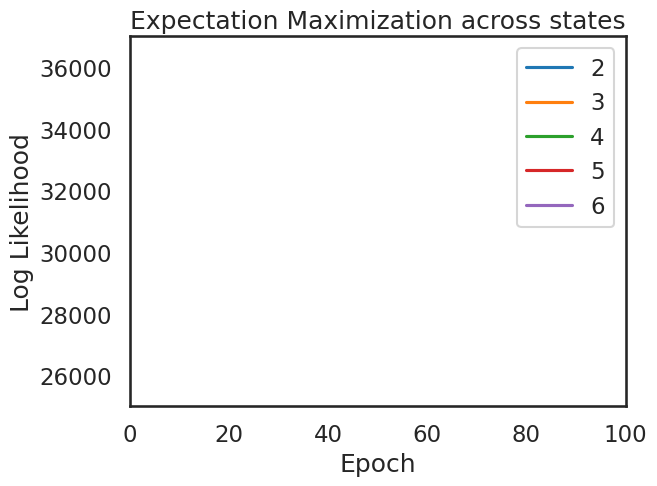

In [26]:
for x in all_lps:
    plt.plot(x, "-")
plt.legend(range(min_state, max_state))
plt.ylim(25000, 37000)
plt.xlim(0, 100)

plt.title("Expectation Maximization across states")
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")

In [27]:
def cross_validate(all_models, all_params, emissions, inputs):
    cross_valids = []

    for model_idx in range(len(all_models)):
        print(f'Cross Validating: {model_idx} model')
        state_log_probs = []
        for validation_idx in range(len(emissions)):
            log_prob = all_models[model_idx].marginal_log_prob(all_params[model_idx], emissions[validation_idx], inputs=inputs[validation_idx])
            state_log_probs.append(float(log_prob))
        cross_valids.append(state_log_probs)

    return np.array(cross_valids)

In [28]:
cross_train = cross_validate(all_models, all_params, train_emissions[::20], train_inputs[::20])


Cross Validating: 0 model
Cross Validating: 1 model
Cross Validating: 2 model
Cross Validating: 3 model
Cross Validating: 4 model


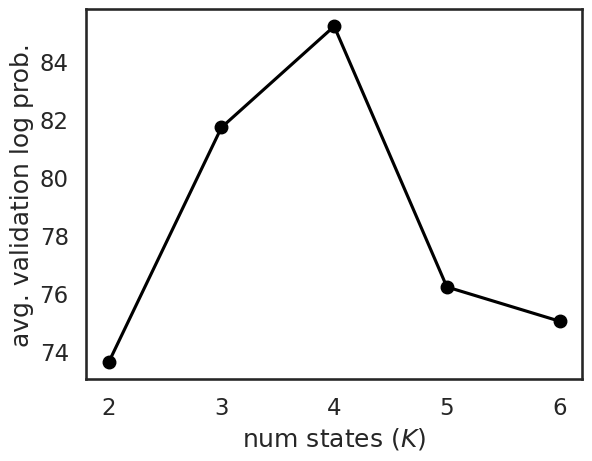

In [29]:
plot_validation(cross_valids=cross_train, show_var=False, max_states=max_state)

In [30]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

# for i in range(2):
#     inspect_sample(5-2, i)

In [36]:

model_to_check = 4

fourth = all_models[model_to_check - 2]
p_fourth = all_params[model_to_check - 2]

In [32]:
# print("transitions", p_fourth.transitions.transition_matrix)
# print("weights", p_fourth.emissions.weights)
# print("biases", p_fourth.emissions.biases)
# print("covs", p_fourth.emissions.covs)

In [37]:
p_fourth.emissions.covs

Array([[[3.7223995e-07]],

       [[2.0002611e-03]],

       [[9.3185222e-03]],

       [[4.4604161e-04]]], dtype=float32)

| state 1 | bias 0.015645276755094528 | covs 3.7223995263957477e-07 |
--------------------------------------------------
| state 2 | bias 0.5951983332633972 | covs 0.0020002610981464386 |
--------------------------------------------------
| state 3 | bias 0.4767814576625824 | covs 0.009318522177636623 |
--------------------------------------------------
| state 4 | bias 0.07935220003128052 | covs 0.00044604160939343274 |
--------------------------------------------------


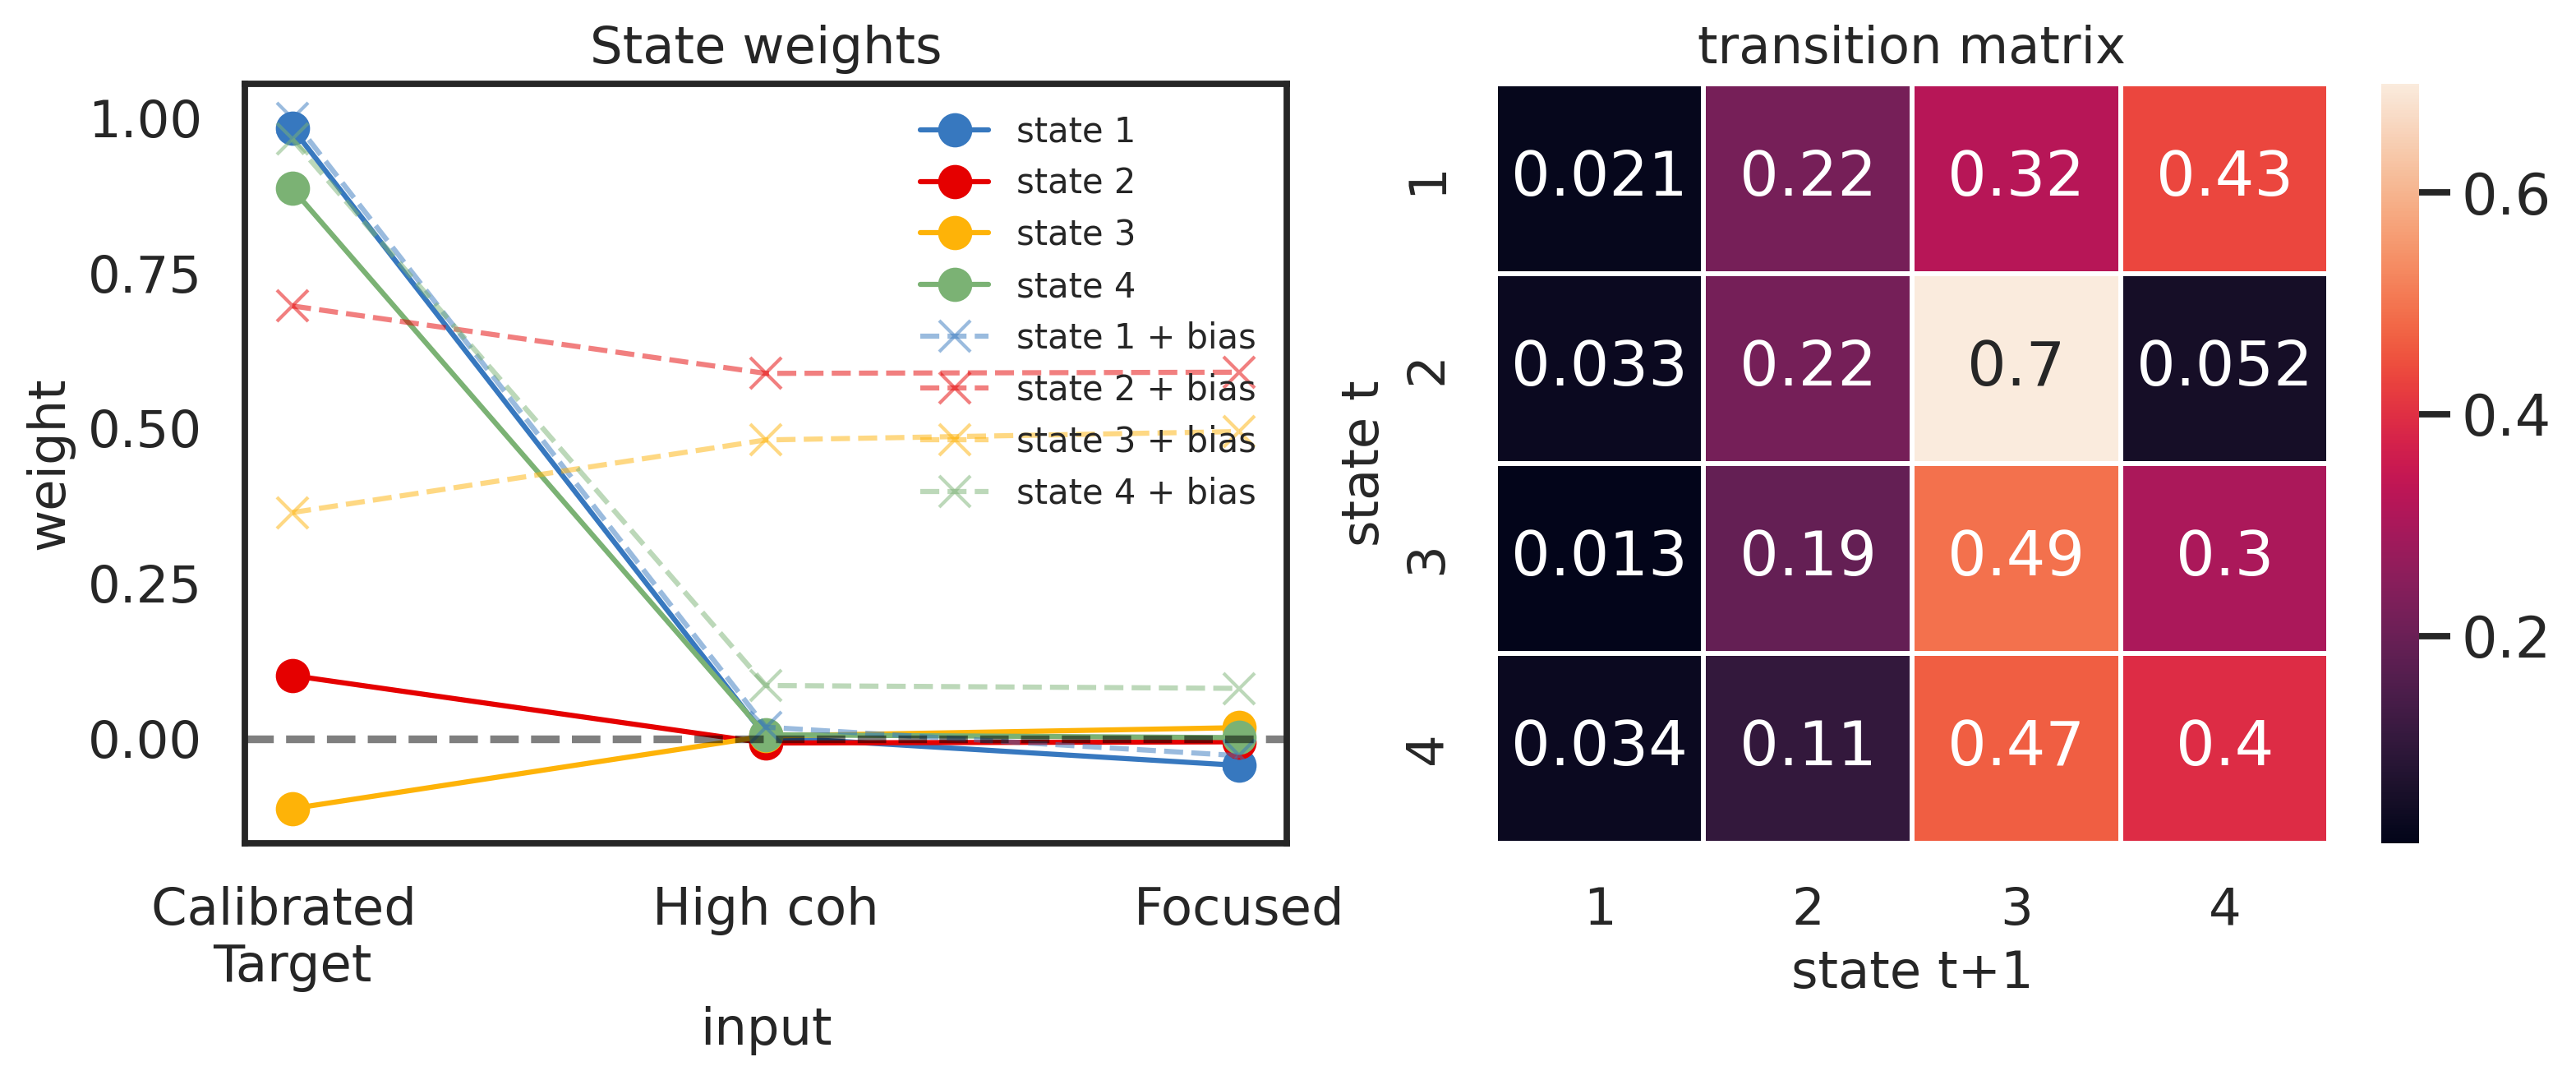

In [38]:
curr_states = model_to_check

# Plot MLE parameters:
fig = plt.figure(figsize=(12*1, 4*1), dpi=300, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = colors
for k in range(curr_states):
    plt.plot(range(input_dim), p_fourth.emissions.weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))

for k in range(curr_states):
    plt.plot(range(input_dim), p_fourth.emissions.weights[k][0] + p_fourth.emissions.biases[k], marker='x',
             color=cols[k], linestyle='--', alpha = 0.5,
             lw=1.5, label=f"state {k+1} + bias")

plt.yticks(fontsize=15)
plt.ylabel("weight", fontsize=15)
plt.xlabel("input", fontsize=15)
# plt.xticks([0, 1, 2, 3], ['target', 'coherance', 'focus', 'bias (0)'], fontsize=10, rotation=45)
plt.xticks([0, 1, 2], ['Calibrated \nTarget', 'High coh', 'Focused'], fontsize=15, rotation=0)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
# transparant boundery for legend
plt.legend(framealpha = 0, fontsize=10)
plt.title("State weights", fontsize = 15)




plt.subplot(1, 2, 2)
gen_trans_mat = p_fourth.transitions.transition_matrix
sns.heatmap(gen_trans_mat, annot=True, linewidths=1, linecolor='white')
# put the ticks 
plt.xticks(np.arange(curr_states) + 0.5, np.arange(curr_states) + 1, fontsize=15)
plt.yticks(np.arange(curr_states) + 0.5, np.arange(curr_states) + 1, fontsize=15)
# set font size of heatmap annotations
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("transition matrix", fontsize = 15)

bias = p_fourth.emissions.biases.reshape(-1).tolist()
covs = p_fourth.emissions.covs.reshape(-1).tolist()

for i in range(curr_states):
    print("| state", i+1, "| bias", bias[i], "| covs", covs[i], "|")
    print("-"*50)

| state 1 | bias 0.08681371808052063 | covs 0.0005603408790193498 |
--------------------------------------------------
| state 2 | bias 0.5460273027420044 | covs 0.011760443449020386 |
--------------------------------------------------


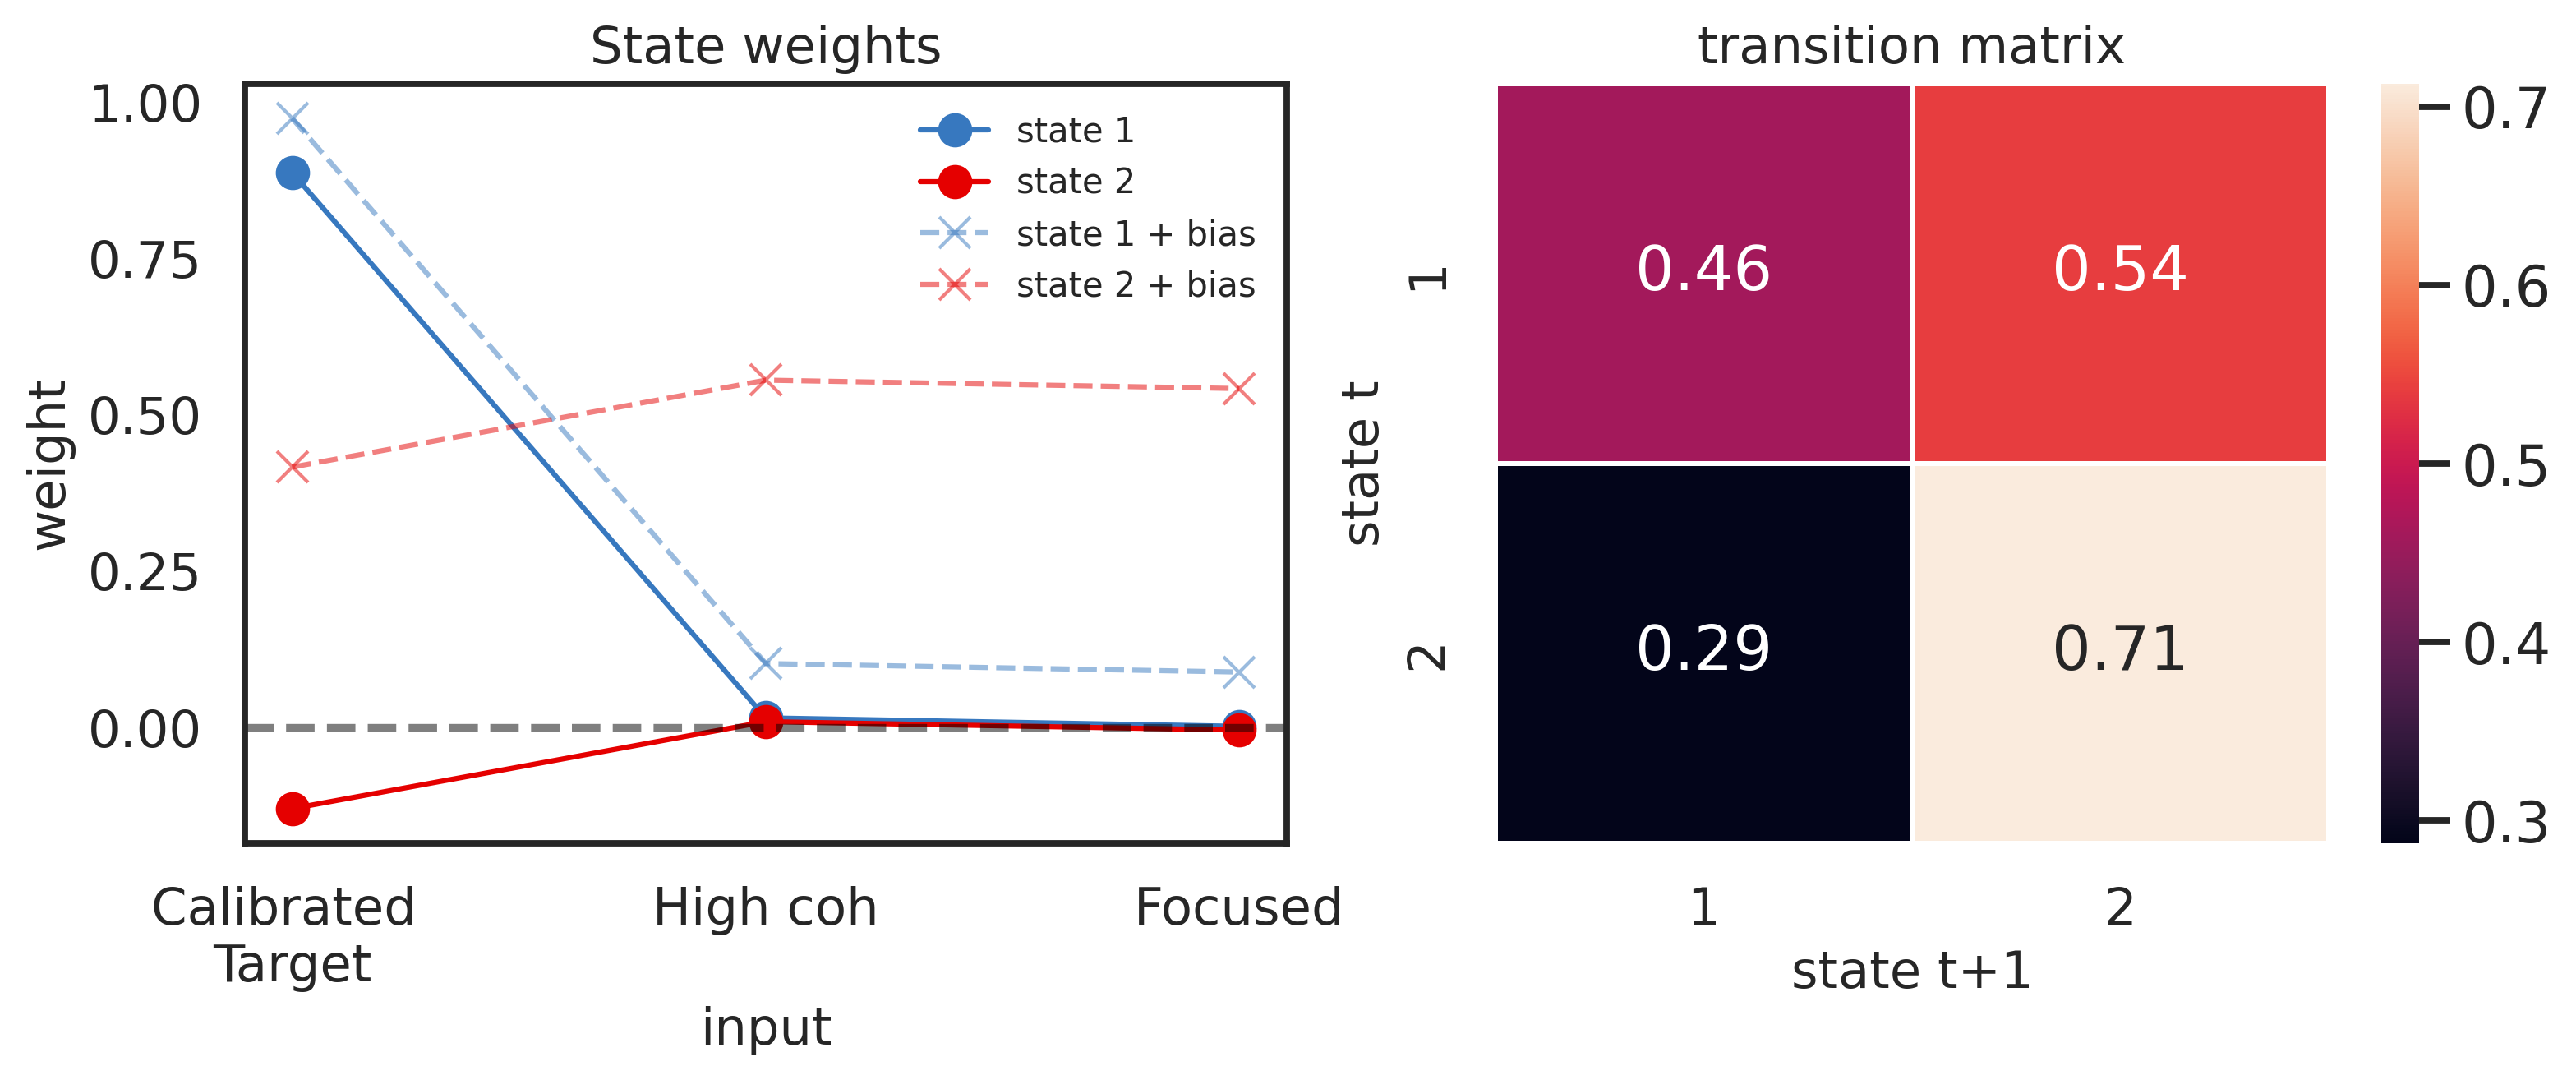

In [35]:
curr_states = model_to_check

# Plot MLE parameters:
fig = plt.figure(figsize=(12*1, 4*1), dpi=300, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = colors
for k in range(curr_states):
    plt.plot(range(input_dim), p_fourth.emissions.weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))

for k in range(curr_states):
    plt.plot(range(input_dim), p_fourth.emissions.weights[k][0] + p_fourth.emissions.biases[k], marker='x',
             color=cols[k], linestyle='--', alpha = 0.5,
             lw=1.5, label=f"state {k+1} + bias")

plt.yticks(fontsize=15)
plt.ylabel("weight", fontsize=15)
plt.xlabel("input", fontsize=15)
# plt.xticks([0, 1, 2, 3], ['target', 'coherance', 'focus', 'bias (0)'], fontsize=10, rotation=45)
plt.xticks([0, 1, 2], ['Calibrated \nTarget', 'High coh', 'Focused'], fontsize=15, rotation=0)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
# transparant boundery for legend
plt.legend(framealpha = 0, fontsize=10)
plt.title("State weights", fontsize = 15)




plt.subplot(1, 2, 2)
gen_trans_mat = p_fourth.transitions.transition_matrix
sns.heatmap(gen_trans_mat, annot=True, linewidths=1, linecolor='white')
# put the ticks 
plt.xticks(np.arange(curr_states) + 0.5, np.arange(curr_states) + 1, fontsize=15)
plt.yticks(np.arange(curr_states) + 0.5, np.arange(curr_states) + 1, fontsize=15)
# set font size of heatmap annotations
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("transition matrix", fontsize = 15)

bias = p_fourth.emissions.biases.reshape(-1).tolist()
covs = p_fourth.emissions.covs.reshape(-1).tolist()

for i in range(curr_states):
    print("| state", i+1, "| bias", bias[i], "| covs", covs[i], "|")
    print("-"*50)

In [ ]:
model_to_check, train_emissions.shape

(2, (312, 120, 1))

In [ ]:
model_idx = model_to_check-2
all_posteriors = []

for em_idx in range(train_emissions.shape[0]):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    all_posteriors.append(posterior.predicted_probs)

log_likelihoods.shape (120, 2)


In [ ]:
avg_sess = np.array(all_posteriors).mean(axis=0)
std_sess = np.array(all_posteriors).std(axis=0)

avg_sess.shape, std_sess.shape

((120, 2), (120, 2))

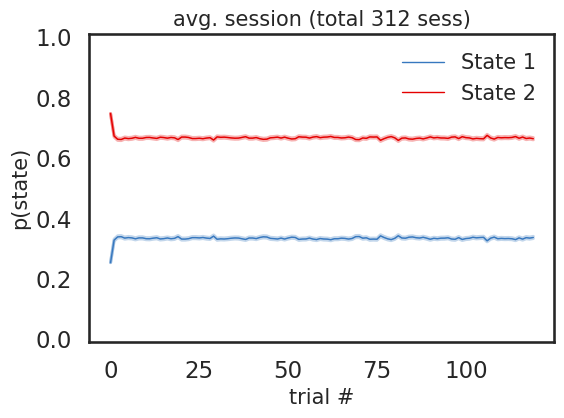

In [ ]:
plt.figure(figsize=(6, 4))

K = model_to_check
total_sessions = train_emissions.shape[0]

for k in range(K):
    plt.plot(avg_sess[:, k], label="State " + str(k + 1), lw=1,
                color=cols[k])
    se = std_sess[:, k] / np.sqrt(total_sessions)
    plt.plot(avg_sess[:, k] + se, color=cols[k], alpha=0.3)
    plt.plot(avg_sess[:, k] - se, color=cols[k], alpha=0.3)

# plt.xticks([0, 45, 90], ["", "", ""], fontsize=15)
# plt.yticks([0, 0.5, 1], ["", "", ""], fontsize=15)
plt.ylim((-0.01, 1.01))
plt.title(f"avg. session (total {total_sessions} sess)", fontsize=15)
plt.xlabel("trial #", fontsize=15)
plt.ylabel("p(state)", fontsize=15)
plt.legend(fontsize=15, framealpha=0)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.xticks([0, 45, 90, 120], ["0", "45", "90", "120"], fontsize=15)
# plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=15)

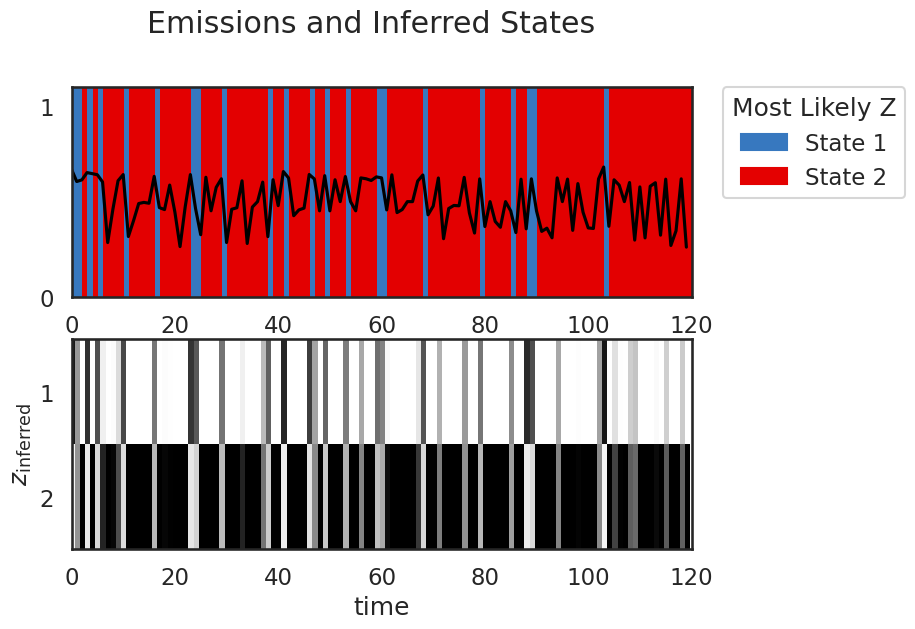

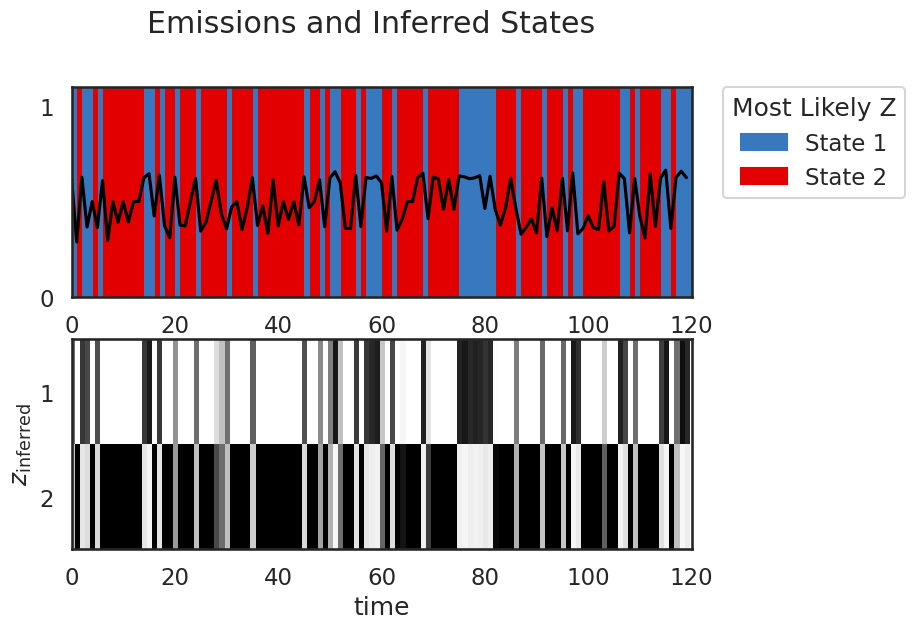

In [ ]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

for i in range(2):
    inspect_sample(model_to_check-2, i)

In [ ]:
from scipy import stats

In [ ]:
p_fourth.emissions.weights

Array([[[ 0.8871814 ,  0.01523993,  0.0016626 ]],

       [[-0.12959597,  0.00919314, -0.00391634]]], dtype=float32)

In [ ]:
p_fourth.emissions.biases

Array([[0.08673533],
       [0.5457837 ]], dtype=float32)

In [ ]:
p_fourth.emissions.covs

Array([[[0.00055868]],

       [[0.01182933]]], dtype=float32)

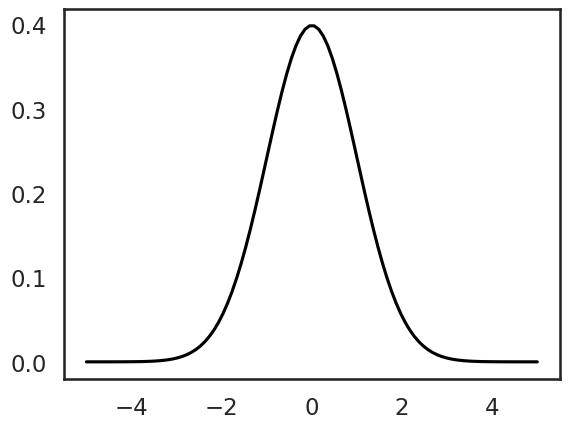

In [ ]:
# given mean and cov, draw the pdf of normal distribution
mu = 0
sigma = 1

x = np.linspace(-5, 5, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), "k-")